In [1]:
import os
import cv2
import glob
import time
import copy
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.preprocessing import normalize

## 資料處理，從標記檔中取得行人影像並依照 reid 分類

In [2]:
def getImagesInDir(dir_path):
    img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
    image_list = []
    for img_format in img_formats:
        for filename in glob.glob(dir_path + f'/*.{img_format}'):
            image_list.append(filename)
    return image_list

In [3]:
classes = ['pedestrian']
img_dir = 'person_reid_datasets/train/JPEGImages/'
ann_dir = 'person_reid_datasets/train/Annotations/'
image_paths = getImagesInDir(img_dir)
out_dir = 'reid/data'

In [4]:
# 創建資料夾
if os.path.exists(out_dir.split('/')[0]):
    shutil.rmtree(out_dir.split('/')[0])  # delete output folder
os.makedirs(out_dir)  # make new output folder

In [5]:
for img_path in tqdm(image_paths, total=len(image_paths)):
    # read image
    img = cv2.imread(img_path)
    
    basename = os.path.basename(img_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(ann_dir + '/' + basename_no_ext + '.xml')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    cnt=0
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        reid = obj.find('reid').text[:-2]
        crop_img = img[int(b[2]):int(b[3]), int(b[0]):int(b[1]), :]
        out_reid_dir = os.path.join(out_dir, reid)
        if not os.path.exists(out_reid_dir):
            os.mkdir(out_reid_dir)
        cv2.imwrite(os.path.join(out_reid_dir, basename_no_ext+'_'+str(cnt))+'.jpg', crop_img)
        cnt+=1

100%|██████████| 723/723 [00:08<00:00, 87.98it/s] 


In [6]:
out_dir = 'reid/data'
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(out_dir):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(each)
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data.head()

,file,class
0,c6s2_058318_4.jpg,624
1,c5s2_049580_3.jpg,624
2,c5s2_070777_4.jpg,624
3,c4s4_050685_1.jpg,624
4,c6s2_058393_1.jpg,624


In [7]:
data.groupby('class').count().sort_values(['file'])

,file
class,
285,1
545,1
714,1
344,2
618,2
...,...
192,45
55,46
173,48


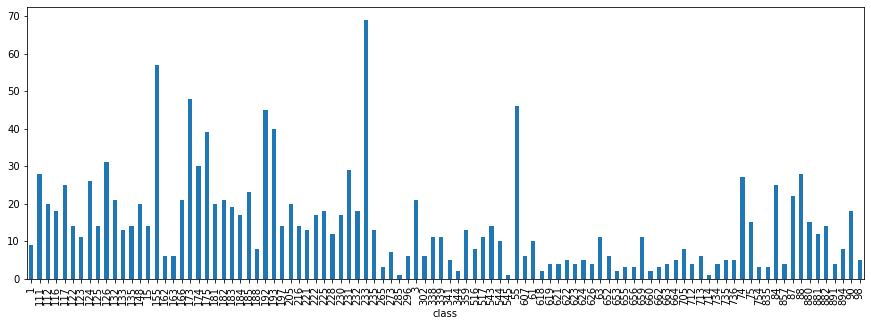

In [8]:
data.groupby('class').count().plot(kind='bar', figsize=(15, 5), legend=False)

In [9]:
class_num = len(data.groupby('class').count())

## 讀入 ReID Pre-trained Model

In [10]:
import torch
import torch.nn as nn
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from model import PCB
reid_model = PCB(751).to(device).eval()
reid_model.load_state_dict(torch.load('pcb.pth') )

<All keys matched successfully>

In [11]:
def load_data(folder_path):
    names = os.listdir(folder_path)
    if '.ipynb_checkpoints' in names:
        names.remove(".ipynb_checkpoints")
    data = {}
    total_person = 0
    for roots, dirs, files in os.walk(folder_path):
        if roots.find(".ipynb_checkpoints") == -1:
            name = roots.split('/')[-1]
            if name in names: 
                data[name] = []
                for file in files:
                    total_person += 1
                    data[name].append(os.path.join(roots, file))
    print('total person:', total_person)
    return data

In [12]:
def get_embeddings(extractor, img):
    img = ((img/255 - (0.485, 0.456, 0.406)) / (0.229, 0.224, 0.225)).astype('float32')
    img = img.transpose((2, 0, 1))
    inputs = np.expand_dims(img, axis=0)
    inputs = torch.from_numpy(inputs).to(device)
    with torch.no_grad():
        embedding = extractor(inputs)
    outputs = normalize(embedding.cpu().numpy()).flatten()
    return outputs

In [13]:
# load face data from database
folder_path = 'reid/data'
data = load_data(folder_path)

total person: 1438


In [14]:
n = len(data)
allembeddings = np.zeros([len(data), 256])
for j, name in tqdm(enumerate(data.keys())):
    embeddings = np.zeros([len(data[name]), 256])
    for i, file in enumerate(data[name]):
        img = cv2.imread(file, cv2.IMREAD_COLOR).astype('float32')
        img = cv2.resize(img[:,:,::-1], (192, 384))
        # extract persons and calculate person embeddings for the photo files
        embeddings[i] = get_embeddings(reid_model, img)
    # calculate mean of the embeddings
    allembeddings[j] = embeddings.mean(0)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100it [00:16,  6.09it/s]


In [15]:
db = {'names': list(data.keys()), 'embeddings': allembeddings}

In [16]:
allembeddings.shape

(100, 256)

# YOLOR + ReID 預測

In [17]:
import sys
sys.path.append('yolor')

## 匯入所需套件

In [18]:
import os
import shutil
import time
import yaml
import pandas as pd
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import matplotlib.pyplot as plt

from utils.google_utils import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer)
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

from models.models import *
from utils.datasets import *
from utils.general import *
%matplotlib inline  

In [19]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 參數設置

In [20]:
weights = 'weights/yolor_p6.pt'
source = 'person_reid_datasets/test/'
sub = 'person_reid_datasets/sample_submission.csv'
cfg = 'cfg/yolor_p6_pedestrian.cfg'
imgsz = 1280
conf_thres = 0.25
iou_thres = 0.5

## 將訓練好的偵測模型權重和 ReID 模型權重讀入到各自的模型中

In [21]:
model = Darknet(cfg, imgsz).to(device).eval()
model.load_state_dict(torch.load(weights, map_location=device)['model'])

<All keys matched successfully>

## 預測影像

In [22]:
dataset = LoadImages(source, img_size=imgsz, auto_size=64)

In [23]:
def compare_persons(db, embedding, threshold):
    # read db
    db_embeddings = db['embeddings']
    db_names = db['names']

    distances = np.zeros((len(db_embeddings)))
    for i, db_embedding in enumerate(db_embeddings):
        distance = round(np.linalg.norm(db_embedding-embedding), 1)
        distances[i] = distance
    idx_min = np.argmin(distances)
    distance, name = distances[idx_min], db_names[idx_min]
    if distance < threshold:
        return name, distance
    else:
        return False, distance

In [24]:
submission = pd.read_csv(sub)
submission = submission.drop([0])
# Run inference
with torch.no_grad():
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img) # run once
    for path, img, im0s, vid_cap in dataset:
        basename = os.path.basename(path)
        basename_no_ext = os.path.splitext(basename)[0]
        
        h, w, _ = im0s.shape
        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        # Inference
        t1 = time_synchronized()
        pred = model(img)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres)
        t2 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0 = path, '', im0s
#             save_path = str(Path(out) / Path(p).name)
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g' % n  # add to string

                # Write results
                for *xyxy, conf, cls in det:
                    crop_img = im0[int(xyxy[1]):int(xyxy[3]), int(xyxy[0]):int(xyxy[2])]
                    crop_img_resize = cv2.resize(crop_img[:,:,::-1], (192, 384))
                    crop_img_resize = ((crop_img_resize/255 - (0.485, 0.456, 0.406)) / (0.229, 0.224, 0.225)).astype('float32') # 0 - 255 to 0.0 - 1.0
                    crop_img_resize = crop_img_resize.transpose((2, 0, 1))
                    crop_img_resize = np.expand_dims(crop_img_resize, 0)
                    crop_img_resize = torch.from_numpy(crop_img_resize).to(device)
                    with torch.no_grad():
                        preds = reid_model(crop_img_resize)
                        embedding = normalize(preds.cpu())
                        matches = compare_persons(db, embedding, 2)
                        distance = matches[1]
                        if False not in matches:
                            reid = matches[0]
                    submission.loc[len(submission)] = [basename_no_ext,
                                                       reid,
                                                       float(conf.cpu()),
                                                       int(xyxy[0].cpu())/w,
                                                       int(xyxy[1].cpu())/h,
                                                       int(xyxy[2].cpu())/w,
                                                       int(xyxy[3].cpu())/h]
            print(s)
#                     plot_one_box(xyxy, im0, label=reid, color=colors[class_names.index(reid)], line_thickness=1)
#             cv2.imwrite(save_path, im0)
#     print('Results saved to %s' % Path(out))
    print('Done. (%.3fs)' % (time.time() - t0))

image 1/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_01.jpg: 768x1280 4
image 2/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_02.jpg: 768x1280 2
image 3/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_03.jpg: 768x1280 3
image 4/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_04.jpg: 768x1280 4
image 5/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_05.jpg: 768x1280 2
image 6/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_06.jpg: 768x1280 4
image 7/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_07.jpg: 768x1280 4
image 8/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_08.jpg: 768x1280 4
image 9/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_09.jpg: 768x1280 7
image 10/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_10.jpg: 768x1280 3
image 11/153 /home/jovyan/Person_ReID/person_reid_datasets/test/c1_11.jpg: 768x1280 4
image 12/153 /home/jovyan/Person_ReID/person_reid_datasets/test

In [25]:
submission.to_csv('submission_yolor_p6_pcb.csv', index=False)

In [26]:
import numpy as np
import pandas as pd
from mean_average_precision.detection_map import DetectionMAP
answer = pd.read_csv('answer.csv')
submission = pd.read_csv('submission_yolor_p6_pcb.csv')

filenames = np.unique(answer['filename'])
class_names = [  1,   3,  15,  55,  61,  63,  74,  75,  84,  87,  88,  90,  98,
       111, 112, 116, 117, 122, 123, 124, 125, 126, 132, 133, 135, 148,
       155, 162, 163, 166, 173, 174, 175, 181, 182, 183, 184, 185, 188,
       192, 193, 197, 205, 216, 221, 222, 225, 228, 230, 231, 232, 233,
       235, 265, 273, 285, 296, 302, 338, 339, 341, 344, 359, 516, 517,
       543, 544, 545, 607, 618, 619, 621, 622, 623, 624, 626, 652, 653,
       655, 656, 659, 660, 662, 663, 664, 705, 712, 713, 714, 734, 735,
       736, 754, 835, 857, 880, 881, 882, 891, 894]
cls_name_dict = {k:v for v, k in enumerate(class_names)}
submission['reid'] = submission['reid'].map(cls_name_dict)
answer['reid'] = answer['reid'].map(cls_name_dict)

In [27]:
frames = []
for file in filenames:
    sub = submission[submission['filename']==file]
    ans = answer[answer['filename']==file]
    pred_bb = sub[['left', 'top', 'right', 'bottom']].values
    pred_cls = sub['reid'].values
    pred_conf = sub['confidence'].values
    gt_bb = ans[['left', 'top', 'right', 'bottom']].values
    gt_cls = ans['reid'].values
    frames.append((pred_bb, pred_cls, pred_conf, gt_bb, gt_cls))

In [28]:
n_class = len(class_names)

thresh = [0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]
mAP_all = []
for thre in thresh:
    mAP = DetectionMAP(n_class, overlap_threshold=thre)
    for i, frame in enumerate(frames):
    #     print("Evaluate frame {}".format(i))
    #     show_frame(*frame)
        mAP.evaluate(*frame)
    print('mAP@' + str(thre)[1:] + f': {mAP.compute_mAP()}')
    mAP_all.append(mAP.compute_mAP())

print(f'mAP@.5:.95: {np.average(mAP_all)}')
# print('mAP:', mAP.compute_mAP())
# mAP.plot(class_names=class_names, figsize=30)
# plt.show()
#plt.savefig("pr_curve_example.png")

mAP@.5: 0.875156265085193
mAP@.55: 0.8737276936566214
mAP@.6: 0.8723501426362132
mAP@.65: 0.8673703446564153
mAP@.7: 0.8607702202437909
mAP@.75: 0.8212202106711634
mAP@.8: 0.7669317179625168
mAP@.85: 0.6422264198357572
mAP@.9: 0.47855256551570524
mAP@.95: 0.3585903867260264
mAP@.5:.95: 0.7416895966989403
